Data:
title/source - headlines from telegram news aggregator 
return_after_1d - how much in percents price changed after title announcment
weighted - custom weight derrived from volume, return_after_1d, exponential moving average for 12h buy and sell volume

In [3]:
import pandas as pd
df_ok = pd.read_csv('filtered_for_classification.csv')
df_ok

,Unnamed: 0,title,source,datetime,return_after_1d,weighted
0,0,Visa Makes Their Grand Entrance Into the NFT A...,Watcher Guru,2021-08-23 20:55:03,-2.255187,-0.578110
1,1,Have you seen our billboard in Times Square to...,Watcher Guru,2021-08-26 03:07:52,-2.880761,-0.614835
2,2,Record breaking sale for Bored Ape,Watcher Guru,2021-08-26 22:14:54,3.342732,0.555237
3,5,Subscribe to our new YouTube Channel:,Watcher Guru,2021-10-09 21:25:19,0.196548,0.416093
4,8,"Join our discord server, big stuff coming soon :",Watcher Guru,2021-11-06 18:40:12,2.596537,0.529590
...,...,...,...,...,...,...
12454,20282,Bitcoin liquidity on weekends is showing signs...,unfolded.,2025-03-28 04:10:37,-3.011766,-0.865066
12455,20283,NY AG files $200 million settlement with Galax...,unfolded.,2025-03-28 09:28:05,-1.801569,-0.797618
12456,20284,Terraform Labs to open crypto creditor claims ...,unfolded.,2025-03-28 15:38:46,-2.315566,-0.690030
12457,20285,FDIC clarifies that banks can engage in permit...,unfolded.,2025-03-28 19:11:54,-1.565353,-0.393629


In [4]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /home/kosmo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/kosmo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kosmo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/kosmo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression  # Example classifier
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Load Data
df = df_ok[['title', 'weighted']]

# Sentiment Binning
def categorize_sentiment(score):
    if score <= -0.6:
        return "very bad"
    elif -0.6 < score <= -0.4:
        return "bad"
    elif -0.4 < score <= 0.4:
        return "neutral"
    elif 0.4 < score < 0.6:
        return "good"
    else:
        return "very good"

df['sentiment'] = df['weighted'].apply(categorize_sentiment)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    #print(' '.join(words))
    return ' '.join(words)

df['cleaned_title'] = df['title'].apply(clean_text)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

param_grid = {
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
    'tfidf__max_df': [0.001,0.01],
    'tfidf__min_df': [0.5,1,2],
    'tfidf__sublinear_tf': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(df['cleaned_title'], df['sentiment'])
print(grid_search.best_params_)


/tmp/ipykernel_103538/158541706.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['weighted'].apply(categorize_sentiment)
/tmp/ipykernel_103538/158541706.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_title'] = df['title'].apply(clean_text)


1. {'tfidf__max_df': 0.7, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3), 'tfidf__sublinear_tf': True}
2. {'tfidf__max_df': 0.5, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3), 'tfidf__sublinear_tf': True}
3. {'tfidf__max_df': 0.3, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3), 'tfidf__sublinear_tf': True}
4. {'tfidf__max_df': 0.01, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3), 'tfidf__sublinear_tf': True}


In [ ]:
from sklearn.svm import SVC


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(kernel='poly', C=1.0,  class_weight='balanced'))
])

param_grid = {
    'tfidf__ngram_range': [(1,2)],
    'tfidf__max_df': [0.01,0.001,0.1],
    'tfidf__min_df': [1, 2],
    'tfidf__sublinear_tf': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(df['cleaned_title'], df['sentiment'])

print(grid_search.best_params_)

50+minutes - {'tfidf__max_df': 0.3, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': False}
40+minutes - {'tfidf__max_df': 0.01, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': False}

sentiment
good         3647
bad          2970
very bad     2883
very good    2301
neutral       658
Name: count, dtype: int64


## RF - very slow - 7min to train

In [ ]:
# from sklearn.metrics import confusion_matrix

# # Train Classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, y_train)

# # Predictions & Evaluation
# y_pred1 = clf.predict(X_test)
# rf_report_1 = (classification_report(y_test, y_pred1))
# rf_cf_1 = confusion_matrix(y_test, y_pred1)



In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_df=0.01, min_df=2, ngram_range=(1, 2), sublinear_tf=False)  #  max_features=5000
X = vectorizer.fit_transform(df['cleaned_title'])
y = df['sentiment']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

svm_clf = SVC(kernel='poly', C=1.0,  class_weight='balanced')  # Linear kernel works well for text classification
svm_clf.fit(X_train2, y_train2)

# Predictions & Evaluation
y_pred2 = svm_clf.predict(X_test2)

# Print Classification Report
svm_report_1 = (classification_report(y_test2, y_pred2))
svm_cf_1 = confusion_matrix(y_test2, y_pred2)

In [65]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

vectorizer = TfidfVectorizer(max_df=0.01, min_df=1, ngram_range=(1, 3), sublinear_tf=True)  #  max_features=5000
X = vectorizer.fit_transform(df['cleaned_title'])
y = df['sentiment']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize Naïve Bayes classifier
nb_clf = MultinomialNB()

# Train the classifier
nb_clf.fit(X_train3, y_train3)

# Predictions & Evaluation
y_pred3 = nb_clf.predict(X_test3)

nb_report_1 = (classification_report(y_test3, y_pred3))
nb_cf_1 = confusion_matrix(y_test3, y_pred3)


/home/kosmo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kosmo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kosmo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Load Data
df = df_ok[['title', 'weighted']]

# Sentiment Binning
def categorize_sentiment(score):
    if score <= -0.5:
        return "bad"
    elif -0.5 < score < 0.5:
        return "neutral"
    else:
        return "good"

df['sentiment'] = df['weighted'].apply(categorize_sentiment)
df['cleaned_title'] = df['title'].apply(clean_text)


y = df['sentiment']

# X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)
# print(df['sentiment'].value_counts())
# print(y_test2.value_counts())
#df[df['sentiment']=='bad']

/tmp/ipykernel_103538/286556858.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['weighted'].apply(categorize_sentiment)
/tmp/ipykernel_103538/286556858.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_title'] = df['title'].apply(clean_text)


In [9]:
# from sklearn.metrics import confusion_matrix

# # Train Classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train2, y_train2)

# # Predictions & Evaluation
# y_pred4 = clf.predict(X_test2)
# rf_report_2 = (classification_report(y_test2, y_pred4))
# rf_cf_2 = confusion_matrix(y_test2, y_pred4)


In [68]:
from sklearn.svm import SVC

vectorizer = TfidfVectorizer(max_df=0.01, min_df=2, ngram_range=(1, 2), sublinear_tf=False)  #  max_features=5000
X = vectorizer.fit_transform(df['cleaned_title'])
y = df['sentiment']

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.2, random_state=42)

svm_clf = SVC(kernel='poly', C=1.0,  class_weight='balanced')  # Linear kernel works well for text classification
svm_clf.fit(X_train4, y_train4)
y_pred5 = svm_clf.predict(X_test4)
svm_report_2 = (classification_report(y_test4, y_pred5))
svm_cf_2 = confusion_matrix(y_test4, y_pred5)

In [69]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

vectorizer = TfidfVectorizer(max_df=0.01, min_df=1, ngram_range=(1, 3), sublinear_tf=True)  #  max_features=5000
X = vectorizer.fit_transform(df['cleaned_title'])
y = df['sentiment']

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.2, random_state=42)

nb_clf = MultinomialNB(alpha=0.01)
nb_clf.fit(X_train5, y_train5)
y_pred6 = nb_clf.predict(X_test5)

nb_report_2 = (classification_report(y_test5, y_pred6))
nb_cf_2 = confusion_matrix(y_test5, y_pred6)


In [70]:
# print('Random forest - 5 features')
# print(rf_report_1)
print('Support Vector Machine - 5 features')
print(svm_report_1)
print('Multinomial Naive Bayes- 5 features')
print(nb_report_1)

print('')
print('')

# print('Random forest - 3 features')
# print(rf_report_2)
print('Support Vector Machine - 3 features')
print(svm_report_2)
print('Multinomial Naive Bayes- 3 features')
print(nb_report_2)

Support Vector Machine - 5 features
              precision    recall  f1-score   support

         bad       0.25      0.21      0.23       586
        good       0.31      0.67      0.42       752
     neutral       0.00      0.00      0.00       129
    very bad       0.28      0.10      0.15       576
   very good       0.30      0.08      0.13       449

    accuracy                           0.29      2492
   macro avg       0.23      0.21      0.19      2492
weighted avg       0.27      0.29      0.24      2492

Multinomial Naive Bayes- 5 features
              precision    recall  f1-score   support

         bad       0.24      0.11      0.15       586
        good       0.31      0.80      0.45       752
     neutral       0.00      0.00      0.00       129
    very bad       0.32      0.12      0.18       576
   very good       0.27      0.03      0.05       449

    accuracy                           0.30      2492
   macro avg       0.23      0.21      0.17      2492
weigh

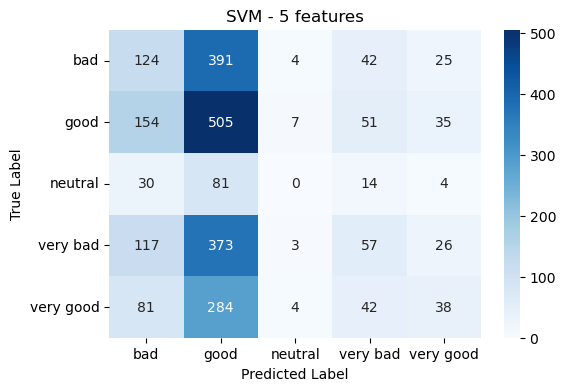

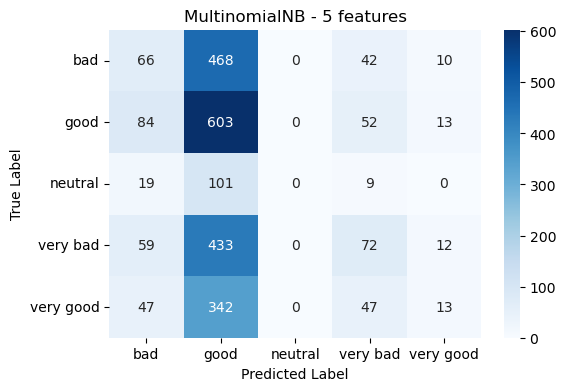

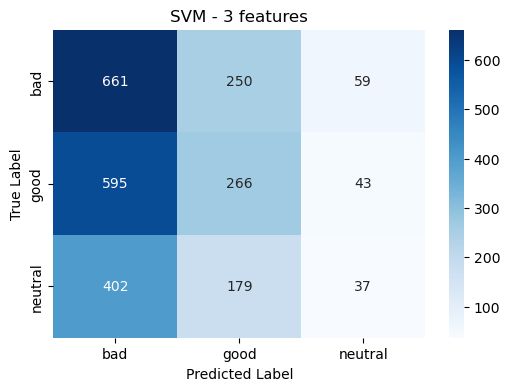

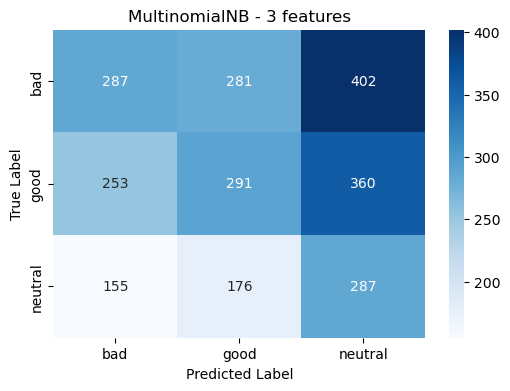

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

labels = np.array(['bad','good','neutral','very bad', 'very good'])


# Plot the confusion matrix
# plt.figure(figsize=(6, 4))
# sns.heatmap(rf_cf_1, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Random forest - 5 features')
# plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(svm_cf_1, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM - 5 features')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(nb_cf_1, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MultinomialNB - 5 features')
plt.show()

# Plot the confusion matrix
# plt.figure(figsize=(6, 4))
# sns.heatmap(rf_cf_2, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test2), yticklabels=set(y_test2))
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Random forest - 3 features')
# plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(svm_cf_2, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test4), yticklabels=set(y_test4))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM - 3 features')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(nb_cf_2, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test5), yticklabels=set(y_test5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MultinomialNB - 3 features')
plt.show()


In [74]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

vectorizer = TfidfVectorizer(max_df=0.01, min_df=1, ngram_range=(1, 3), sublinear_tf=True)

X = vectorizer.fit_transform(df['cleaned_title'])
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_clf = MultinomialNB()

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0],  # Smoothing parameter
    'fit_prior': [True, False],  # Whether to learn class prior probabilities
    'force_alpha': [True, False]  # Ensures `alpha` is used even if n_features is large (only in newer sklearn versions)
}

grid_search = GridSearchCV(nb_clf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluation
print("Best Parameters:", grid_search.best_params_)
# report = classification_report(y_test, y_pred)
# cm = confusion_matrix(y_test, y_pred)


/home/kosmo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kosmo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/kosmo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/kosmo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/kosmo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/kosmo/.local/lib/python3.10/site-packages/sklearn/utils/_response.py", line 207, in _ge

Best Parameters: {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True}


Best Parameters: {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True}


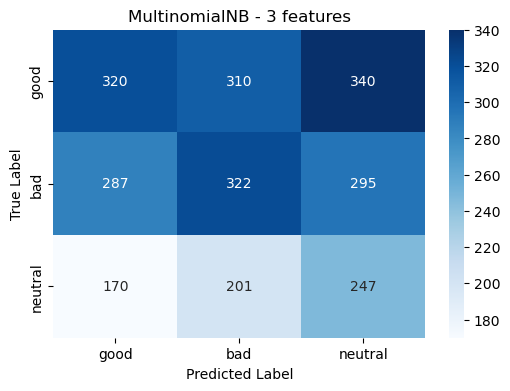

                                                  title sentiment
4189  $5.4 trillion asset manager Fidelity says nati...       bad
5871  The anonymous organisation Unknown Fund intend...   neutral
1107  According to government estimations, crypto mi...   neutral
1142  $590 million has been liquidated from the cryp...      good
5156      Open interest down by 35% from $630m to $400m       bad
...                                                 ...       ...
9921  Price of algorithmic stablecoin UST drops 2% b...       bad
2856  Hong Kong to release crypto & Bitcoin framewor...   neutral
4202  BlackRock launches Spot Bitcoin ETF on CBOE Ca...      good
881   Meta (Facebook) is exploring 3D virtual realit...   neutral
1710              97,052,621 has been minted by Gemini.      good

[2492 rows x 2 columns]


In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns





vectorizer = TfidfVectorizer(max_df=0.01, min_df=1, ngram_range=(1, 3), sublinear_tf=True)  #  max_features=5000
X = vectorizer.fit_transform(df['cleaned_title'])
y = df['sentiment']

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.2, random_state=42)

nb_clf = MultinomialNB(alpha=0.0005, fit_prior=True, force_alpha=True)
nb_clf.fit(X_train5, y_train5)
y_pred6 = nb_clf.predict(X_test5)

nb_report_2 = (classification_report(y_test5, y_pred6))
nb_cf_2 = confusion_matrix(y_test5, y_pred6)

plt.figure(figsize=(6, 4))
sns.heatmap(nb_cf_2, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test5), yticklabels=set(y_test5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MultinomialNB - 3 features')
plt.show()

_, X_demo, _, _ = train_test_split(df['title'], y, test_size=0.2, random_state=42)
df_demo = pd.DataFrame({"title": X_demo, "sentiment": y_pred6})
print(df_demo)



In [13]:
for t in df_demo[df_demo['sentiment']=='bad']['title'].head(20):
    print(t)

$5.4 trillion asset manager Fidelity says nation-states & governments will be the next significant investors that 'might' add Bitcoin to their portfolios.
Open interest down by 35% from $630m to $400m
Sygnum becomes first bank to launch Tezos staking
British Virgin Islands court reportedly orders liquidation of Three Arrows Capital.
Major South Korean bank announces it has filed 46 patents
21shares & Ark filed updated version of its spot Bitcoin ETF S-1 application, allowing cash creations and redemptions (at least to start) |
Elon Musk claims Twitter is trying to hide his counterclaims and has asked a judge to make them public.
Brazil President signs bill to regulate cryptocurrency in the country.
Elon Musk says Apple "mostly stopped advertising on Twitter."
A combined 798 wallets containing $428 million are blocked by and .
Elon Musk has taken full control of Twitter.
Official mugshot of former President Donald Trump.
US Treasury fines crypto exchange Bittrex $53 million for violatin

In [14]:
for t in df_demo[df_demo['sentiment']=='good']['title'].head(20):
    print(t)

$590 million has been liquidated from the cryptocurrency market in the past 24 hours.
Two of the largest trading desks in crypto have alerted clients that they will stop making markets in XRP
Crypto lender Genesis issued $5.2 billion worth of new loans in Q3
Gemini wins Irish electronic money license: report
new ฿ daily high: $37000
Average Bitcoin-fiat spreads decline on major exchanges since January
US Congresswoman Nancy Pelosi's estimated net worth rises to an all-time high of $271,000,000. How is this possible?
‘GoxRising’ movement aims to reboot Mt.Gox exchange, make ‘Gox Coin’ for creditors
- Deepest bitcoin liquidity - Zero trading fees - Trade with leverage, no overloads, no downtime. D - Largest & most liquid BTC and ETH options exchange — unfolded.eth
Bitcoin funding rates are at 3 year highs, while notional OI is up 23,000 BTC over the past 6 days
Sequoia Capital is launching a $500-600 million crypto fund to invest in tokens
Investment bank Citi: Bitcoin is ‘at the tipping